In [ ]:
# note - the old notebook is located at ../school/ai-capstone/CTD_Parkinsons.ipynb

In [91]:
import os
import requests

import numpy as np
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Bidirectional, Normalization, Conv1D, Dropout, MaxPool2D,MaxPooling1D, Flatten
from keras.models import Model

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [1]:
import gzip
import shutil

def download_resource(resource):
    url_dl_pattern = 'http://ctdbase.org/reports/{resource}.csv.gz'
    url = url_dl_pattern.format(resource=resource)
    
    print('downloading: {0}'.format(resource))
    local_filename = 'zipped_data/' + url.split('/')[-1]
    unzipped_filename = 'unzipped_data/' + url.split('/')[-1].replace('.gz', '')
    
    if os.path.isfile(unzipped_filename):
        print('data already exists')
        return 

    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)

    with gzip.open(local_filename, 'rb') as f_in:
        with open(unzipped_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    return local_filename


In [7]:
resources = [
#     'CTD_chem_gene_ixn_types',
#     'CTD_chem_gene_ixns',
#     'CTD_chem_pathways_enriched',
#     'CTD_genes_diseases',
#     'CTD_genes_pathways',
#     'CTD_diseases_pathways',
#     'CTD_pheno_term_ixns',
#     'CTD_exposure_studies',
#     'CTD_chemicals',
#     'CTD_genes',
    'CTD_chemicals_diseases',
    'CTD_diseases'
]

for res in resources:
    download_resource(res)


downloading: CTD_chemicals_diseases
downloading: CTD_diseases


In [8]:
def get_df(resource):
    line_number = 27
    the_file = 'unzipped_data/{resource}.csv'.format(resource=resource)
    with open(the_file, 'r') as reader:
        for i, row in enumerate(reader):
            if i == line_number:
                header = row.replace('# ', '').split(',')

    # print(header)
    df = pd.read_csv(the_file, skiprows=29, names=header)
    return df

In [9]:
df = get_df('CTD_chemicals_diseases')

In [79]:
disease_df = get_df('CTD_diseases')
disease_df[:4]
disease_df['ParentIDs'].str.split('|').explode()

hierarchy_df = disease_df.assign(ParentIDs=disease_df['ParentIDs'].str.split('|')).explode('ParentIDs')

# top_of_tree = 'MESH:D010300' # parkinsons disease
# top_of_tree = 'MESH:D020734' # Parkinsonian Disorders
top_of_tree = 'MESH:D019636' # neurodegenerative diseases
# top_of_tree = 'MESH:D009422' # nervous system diseases
level_one = hierarchy_df.loc[hierarchy_df['ParentIDs'] == top_of_tree]
level_two = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_one['DiseaseID'])]
level_three = hierarchy_df.loc[hierarchy_df['ParentIDs'].isin(level_two['DiseaseID'])]

# to do, do this recursively..
all_diseases = list(level_one['DiseaseID'].unique()) \
             + list(level_two['DiseaseID'].unique()) \
             + list(level_three['DiseaseID'].unique()) \
             + [top_of_tree]


In [12]:
# print(len(df)) # 7,737,679
def get_genes(df, N):
    gene_df = pd.DataFrame(df.groupby(['InferenceGeneSymbol']).size()).reset_index()
    gene_df.columns = ['InferenceGeneSymbol','cnt']
    top_n_genes_df = gene_df.sort_values('cnt', ascending=False)[:N]
    top_n_genes = top_n_genes_df['InferenceGeneSymbol'].unique()
    return top_n_genes

N = 500
top_n_genes = get_genes(df, N)
    

In [73]:
def get_training_data(df):
    
    try:
        return pd.read_csv('gene_network.csv')
    except Exception:
        pass

    gene_df = df.loc[df['DirectEvidence'].isnull()][['ChemicalName', 'DiseaseName', 'InferenceGeneSymbol', 'InferenceScore', 'DiseaseID']]

    gene_df = gene_df.loc[gene_df['InferenceGeneSymbol'].isin(top_n_genes)]

    evidence_df = df.loc[df['DirectEvidence'].notnull()][['ChemicalName', 'DiseaseName', 'DirectEvidence', 'DiseaseID']]
    merged_df = gene_df.merge(evidence_df, on=['ChemicalName', 'DiseaseName', 'DiseaseID'])

    dummy_df = pd.get_dummies(merged_df, prefix='', prefix_sep='',columns=['InferenceGeneSymbol'])
    gb_df = dummy_df.groupby(['DiseaseName', 'ChemicalName', 'DiseaseID']).agg({np.max}).reset_index()

    gb_df.columns = gb_df.columns.droplevel(1)

    gb_df['label'] = np.where(gb_df['DirectEvidence'] == 'marker/mechanism',
                                               gb_df['InferenceScore'] * -1,
                                               gb_df['InferenceScore'])

    gb_df.to_csv('gene_network.csv')
    return gb_df
    
train_df = get_training_data(df)
    

In [81]:
train_df['binary_label'] = np.where(train_df['DiseaseID'].isin(all_diseases),1, 0)
print(train_df.groupby(['binary_label']).size())

print('\n predicting the following diseases:\n', ', '.join(train_df[train_df['DiseaseID'].isin(all_diseases)]['DiseaseName'].unique()))

binary_label
0    50010
1      504
dtype: int64

 predicting the following diseases:
 Adrenoleukodystrophy, Alzheimer Disease, Amyloid Neuropathies, Familial, Amyotrophic Lateral Sclerosis, Amyotrophic lateral sclerosis 1, Ceroid Lipofuscinosis, Neuronal, 6, Ceroid lipofuscinosis, neuronal 1, infantile, Copper-Overload Cirrhosis, Creutzfeldt-Jakob Syndrome, Familial apoceruloplasmin deficiency, Fragile X Syndrome, Hepatolenticular Degeneration, Huntington Disease, Lewy Body Disease, Menkes Kinky Hair Syndrome, Motor Neuron Disease, Myasthenia Gravis, Neurodegenerative Diseases, Neuromyelitis Optica, Optic Atrophy, Hereditary, Leber, Parkinson Disease, Prion Diseases, Scrapie, Shy-Drager Syndrome, Tauopathies, Tuberous Sclerosis


In [119]:
def plot_results(history, predicted_values, y_test, accuracy):
    
    # plot accuracy
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes[0][0].plot(history.history['accuracy'],label='accuracy')
    axes[0][0].plot(history.history['val_accuracy'],label='val_accuracy')
    axes[0][0].text(2, history.history['accuracy'][0] + .005, 'accuracy: {:.4f}'.format(accuracy))

    axes[0][0].legend()

    
    # plot loss
    axes[0][1].plot(history.history['loss'],label='loss')
    axes[0][1].plot(history.history['val_loss'],label='val_loss')
    axes[0][1].legend()
    fig.tight_layout()
    
    fpr, tpr, thresholds = roc_curve (y_test , predicted_values)

    # plot_roc_curve
    auc_score = roc_auc_score(y_test, predicted_values) 

    axes[1][0].plot(fpr,tpr)
    axes[1][0].text(0.7, 0.9, 'auc: {:.4f}'.format(auc_score))
    axes[1][0].axis([-.05,1.1,0,1.05]) 

    # plot confusion matrix
    cm = confusion_matrix(y_test, np.where(predicted_values > 0.5, 1, 0))

    labels = ["Non Target", "Target"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues, ax=axes[1][1]) # xticks_rotation=45

X_train, 10102
X_test,  40412
y_train:  10102
y_test:  40412
1263/1263 [==============================] - 1s 988us/step - loss: 0.0321 - accuracy: 0.9931


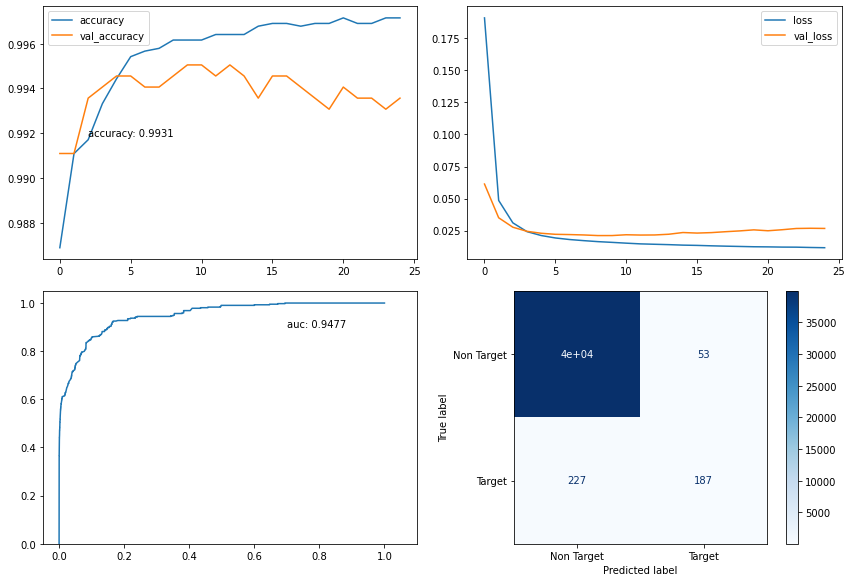

In [127]:
def simple_model(features, labels):
    
    input_shape = features.shape[1]
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=.2)
    
    print('X_train,', len(X_train))
    print('X_test, ', len(X_test))
    print('y_train: ',len(y_train))
    print('y_test: ', len(y_test))
    
    model = Sequential()
    model.add(Dense(60, input_dim=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    callbacks = []
    # if self.stop_early:
    #    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

    history = model.fit(X_train,
                        y_train,
                        epochs=25,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=False
                       )
    predicted_values = model.predict(X_test)
    loss, accuracy = model.evaluate(X_test, y_test)
    plot_results(history, predicted_values, y_test, accuracy)
    
    
    return history, model


shuffled_df = train_df.sample(frac=1)
history, model = simple_model(shuffled_df[top_n_genes], shuffled_df['binary_label'])



Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 499, 64)           192       
                                                                 
 dense_50 (Dense)            (None, 499, 16)           1040      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 249, 16)          0         
 g1D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 3984)              0         
                                                                 
 dense_51 (Dense)            (None, 1)                 3985      
                                                                 
Total params: 5,217
Trainable params: 5,217
Non-trainable params: 0
___________________________________________________

1421/1421 [==============================] - 4s 3ms/step - loss: 0.0569 - accuracy: 0.9893


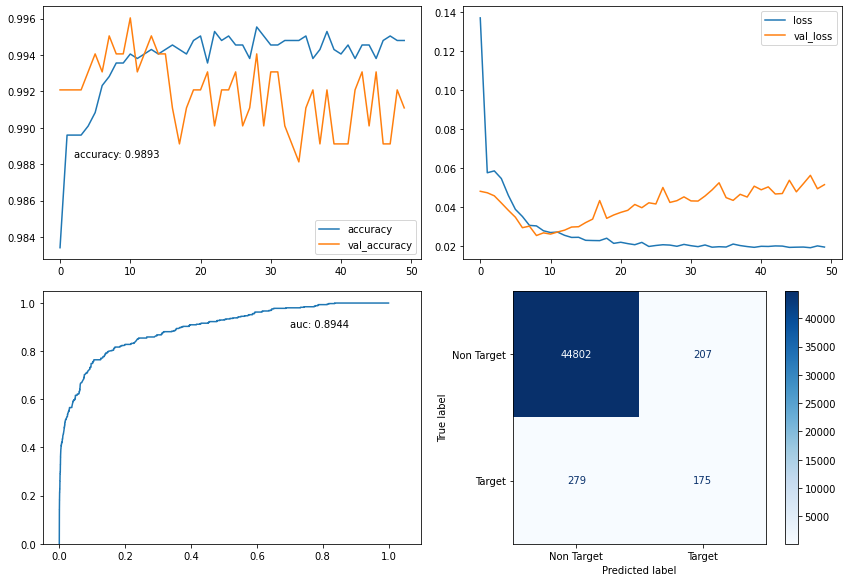

In [124]:
def cnn_model(features, labels, stop_early=False):
    layer_numbers = 2        
    pct_nodes_to_drop = .2
    model = Sequential()

    model.add(Conv1D(64, 2, activation="relu", input_shape=(len(features.columns),1)))
    model.add(Dense(16, activation="relu"))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    model.summary()

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, train_size=.1)
    
    callbacks = []
    if stop_early:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2))

    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=callbacks,
                        verbose=True
                       )
    predicted_values = model.predict(X_test)
    loss, accuracy = model.evaluate(X_test, y_test)
    plot_results(history, predicted_values, y_test, accuracy)
    

cnn_model(shuffled_df[top_n_genes], shuffled_df['binary_label'])

